# Optuna 

## Prepare Environment

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna.visualization as optvis
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import gc

In [4]:
def opt_plot(study, plot):
    if plot == 0: return optvis.plot_optimization_history(study)
    if plot == 1: return optvis.plot_slice(study)
    if plot == 2: return optvis.plot_parallel_coordinate(study)
    if plot == 3: return optvis.plot_contour(study)
    if plot == 4: return optvis.plot_param_importances(study)

## Load and Prepare Data

In [5]:
train_id = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

print(f'Size of train_id - rows: {train_id.shape[0]}, columns: {train_id.shape[1]}')
print(f'Size of train_transaction - rows:{train_transaction.shape[0]}, columns: {train_transaction.shape[1]}')

Size of train_id - rows: 144233, columns: 41
Size of train_transaction - rows:590540, columns: 394


In [6]:
train = train_transaction.merge(train_id,on=['TransactionID'],how='left') 
print(f'Size of train - rows : {train.shape[0]}, columns : {train.shape[1]}')

Size of train - rows : 590540, columns : 434


In [7]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
train_GB = (train.memory_usage(deep = True).sum()/1024**3)


print(f'The train dataframe is taking up about {train_GB:.2f} GB of memory storage')

The train dataframe is taking up about 2.51 GB of memory storage


# Memory Optimization

In [9]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(train)

Initial memory usage of dataframe is 2571.60 MB/2.51 GB
Memory usage after optimization is: 530.21 MB/0.52 GB
Decreased by 79.4%


### Check for Missing Values

In [10]:
total_mv= train.isnull().sum().to_frame()#round to whole number 
percent_mv = (train.isnull().sum()/train.isnull().count()*100)   # round to 2 dp

pd.concat([total_mv, percent_mv], axis=1, keys=['Total Missing Values', 'Percent']).transpose()

,,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total Missing Values,0,0.0,0.0,0.0,0.0,0.0,0.0,8933.000000,1565.000000,1577.000000,4259.000000,...,450258.000000,512954.000000,517251.000000,512735.000000,449555.000000,449555.000000,449555.000000,449555.000000,449730.000000,471874.00000
Percent,0,0.0,0.0,0.0,0.0,0.0,0.0,1.512683,0.265012,0.267044,0.721204,...,76.245132,86.861855,87.589494,86.824771,76.126088,76.126088,76.126088,76.126088,76.155722,79.90551


### Label Distribution

In [11]:
target_count = train['isFraud'].value_counts()
target_percent = train['isFraud'].value_counts()/len(train)

print('Target Column : isFraud')
pd.concat([ target_count, target_percent], axis=1, keys=['Count', 'Percent'])

Target Column : isFraud


,Count,Percent
0,569877,0.96501
1,20663,0.03499


<AxesSubplot: title={'center': 'Count of Fraudulent vs Non-Fraudulent Transactions'}, xlabel='Fraudulent(Yes/No)', ylabel='Count of Transactions'>

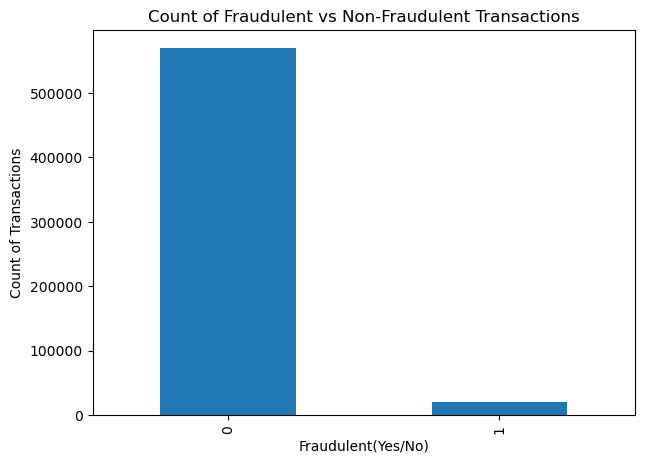

In [12]:
train['isFraud'].value_counts().plot(kind='bar', 
                                     figsize=(7, 5), 
                                     xlabel = "Fraudulent(Yes/No)",
                                     ylabel ="Count of Transactions",
                                     title= "Count of Fraudulent vs Non-Fraudulent Transactions")

Target feature is unbalanced. needs to be balanced

### Feature Engineering and Preprocessing

In [13]:
y_train = train.isFraud.values
train.drop(['TransactionID', 'isFraud'], axis=1, inplace=True)
X_train = train

In [14]:
cat_features = ['ProductCD', 'card1','card2','card3','card4','card5','card6', 'addr1','addr2', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13','id_14','id_15',
                'id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31',
                'id_32','id_33','id_34','id_35','id_36','id_37','id_38']

num_features = [x for x in train.columns.values if x not in cat_features]  #slicing from 2 onwards ( first 2 columns are identifier and target)

features = num_features + cat_features

print('Categorical features :', len(cat_features))
print('Numerical features : ',len(num_features))

Categorical features : 49
Numerical features :  383


In [15]:
train_idx, valid_idx = train_test_split(range(len(X_train)), test_size=0.8, random_state=1, stratify=y_train)

print(len(train_idx))
print(len(valid_idx))

indices = [(train_idx, valid_idx)]

118108
472432


In [16]:
del train
gc.collect()

11

### LightGBM

In [17]:
%%time 

def lgbm_objective(trial):
    
    n  = trial.suggest_int('n_estimators', 20, 150)
    md = trial.suggest_int('max_depth', 2, 40)
    nl = trial.suggest_int('num_leaves', 50, 500)
    lr = trial.suggest_float('learning_rate', 0, 1, log=False)
    ss = trial.suggest_float('subsample', 0.6, 1, log=False)
    nj = trial.suggest_int('n_jobs', 1, 4) 
    bt = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    
    
    clf =  LGBMClassifier(n_estimators=n, max_depth=md, learning_rate=lr, boosting_type=bt,num_leaves = nl, n_jobs = nj,
                          subsample=ss, random_state=1)
    
    scores = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=indices, scoring='roc_auc')
    return scores.mean()
    
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=20)

print()
print(lgbm_study.best_value)
print(lgbm_study.best_params)

[I 2022-11-16 00:08:11,562] A new study created in memory with name: no-name-cd095eff-e5e6-49e3-bed9-1a1df351e266
[I 2022-11-16 00:08:35,773] Trial 0 finished with value: 0.6136664350045002 and parameters: {'n_estimators': 150, 'max_depth': 40, 'num_leaves': 68, 'learning_rate': 0.6940709092332584, 'subsample': 0.9808410123227262, 'n_jobs': 2, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6136664350045002.
[I 2022-11-16 00:08:50,706] Trial 1 finished with value: 0.9235048551351381 and parameters: {'n_estimators': 97, 'max_depth': 7, 'num_leaves': 300, 'learning_rate': 0.18636496411691417, 'subsample': 0.7725145577604872, 'n_jobs': 4, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.9235048551351381.
[I 2022-11-16 00:09:10,079] Trial 2 finished with value: 0.5493077992401243 and parameters: {'n_estimators': 113, 'max_depth': 18, 'num_leaves': 388, 'learning_rate': 0.5781162286485346, 'subsample': 0.6199611277819779, 'n_jobs': 2, 'boosting_type': 'gbdt'}. Best is trial 1


0.9318018420888221
{'n_estimators': 104, 'max_depth': 32, 'num_leaves': 290, 'learning_rate': 0.2532709909010908, 'subsample': 0.918154207164955, 'n_jobs': 3, 'boosting_type': 'goss'}
CPU times: total: 4.61 s
Wall time: 6min 42s


In [18]:
print(lgbm_study.best_value)
print(lgbm_study.best_params)

0.9318018420888221
{'n_estimators': 104, 'max_depth': 32, 'num_leaves': 290, 'learning_rate': 0.2532709909010908, 'subsample': 0.918154207164955, 'n_jobs': 3, 'boosting_type': 'goss'}


In [19]:
opt_plot(lgbm_study, plot=0)

In [20]:
opt_plot(lgbm_study, plot=1)

# Train Final Model

In [21]:
final_model = lgb_model = LGBMClassifier(random_state=1, **lgbm_study.best_params)
final_model.fit(X_train, y_train)

print(final_model.score(X_train, y_train))

0.9990381684559895


# Load and Process Test Data

In [22]:
test_id = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

print(f'Size of test_id - rows: {test_id.shape[0]}, columns: {test_id.shape[1]}')
print(f'Size of test_transaction - rows: {test_transaction.shape[0]}, columns: {test_transaction.shape[1]}')

FileNotFoundError: [Errno 2] No such file or directory: '../input/ieee-fraud-detection/test_identity.csv'

In [ ]:
test = test_transaction.merge(test_id,on=['TransactionID'],how='left') 
print(f'Size of test - rows : {test.shape[0]}, columns : {test.shape[1]}')

Size of test - rows : 506691, columns : 433


In [ ]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_GB = test.memory_usage(deep = True).sum()/1024**3 
print(f'test dataframe is using {test_GB:.2f} GB of memory storage')

test dataframe is using 2.17 GB of memory storage


In [ ]:
del test_id
del test_transaction
gc.collect

<function gc.collect(generation=2)>

# Memory Optimization

In [ ]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

test = reduce_mem_usage(test)

Initial memory usage of dataframe is 2217.90 MB/2.17 GB
Memory usage after optimization is: 462.24 MB/0.45 GB
Decreased by 79.2%


In [ ]:
test.drop(['TransactionID'], axis=1, inplace=True)


In [ ]:
test.rename(columns = {'id-01':'id_01','id-02':'id_02','id-03': 'id_03','id-04': 'id_04','id-05': 'id_05','id-06': 'id_06',
              'id-07': 'id_07','id-08': 'id_08','id-09': 'id_09','id-10': 'id_10','id-11': 'id_11','id-12': 'id_12', 
              'id-13': 'id_13','id-14': 'id_14','id-15': 'id_15','id-16': 'id_16','id-17': 'id_17','id-18': 'id_18',
              'id-19': 'id_19','id-20': 'id_20','id-21': 'id_21','id-22': 'id_22','id-23': 'id_23','id-24': 'id_24',
              'id-25': 'id_25','id-26': 'id_26','id-27': 'id_27','id-28': 'id_28','id-29': 'id_29','id-30': 'id_30',
              'id-31': 'id_31','id-32': 'id_32','id-33': 'id_33','id-34': 'id_34','id-35': 'id_35','id-36': 'id_36',
              'id-37': 'id_37','id-38': 'id_38'}, inplace = 1)

# Test Predictions

In [ ]:
X_test = test

In [ ]:
test_pred= final_model.predict_proba(X_test)
print(test_pred.shape)

(506691, 2)


# Submission

In [ ]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [ ]:
submission.isFraud = test_pred[:, 1]
submission.head()

,TransactionID,isFraud
0,3663549,0.000561
1,3663550,0.000947
2,3663551,0.004099
3,3663552,0.002136
4,3663553,0.000906


In [ ]:
submission.to_csv('ieee_lgbm_optuna_all.csv', index=False, header=True)

In [26]:
import lightgbm as lgb
SEED = 42
import numpy as np
np.random.seed(SEED)

def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
    )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [27]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=100, timeout=600)

[I 2022-11-16 00:29:39,486] A new study created in memory with name: no-name-8b367de2-41ed-4356-bb92-b964b201e214
c:\Users\ajaoo\miniconda3\envs\topic_env\Lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

c:\Users\ajaoo\miniconda3\envs\topic_env\Lib\site-packages\lightgbm\basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

c:\Users\ajaoo\miniconda3\envs\topic_env\Lib\site-packages\lightgbm\basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2022-11-16 00:29:56,506] Trial 0 finished with value: 0.9787719714159921 and parameters: {'bagging_fraction': 0.6247240713084175, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 0 with value: 0.9787719714159921.
c:\Users\ajaoo\miniconda3\envs\topic_env\Lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval

In [28]:
plot_optimization_history(study)

In [29]:
plot_intermediate_values(study)

In [30]:
plot_parallel_coordinate(study)

In [31]:
plot_parallel_coordinate(study, params=["bagging_freq", "bagging_fraction"])

In [32]:
plot_contour(study)

In [33]:
plot_contour(study, params=["bagging_freq", "bagging_fraction"])

In [34]:
plot_slice(study)

In [35]:
plot_slice(study, params=["bagging_freq", "bagging_fraction"])

In [36]:
plot_param_importances(study)

In [37]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [38]:
plot_edf(study)